 # A tutorial on 'Soft weight-sharing for Neural Network compression'

## Introduction

Recently, compression of neural networks has been a much-discussed issue.  One reason for this is the desire to run and store them on mobile devices such as smartphones, robots or [Rasberry Pis](https://github.com/samjabrahams/tensorflow-on-raspberry-pi). Another problem is the energy consumption of a multimillion parameter network. When inference is run at scale the costs can quickly add up.

Compressing a given neural network is a challenging task. While the idea of storing weights with low precision has been around for some time, ideas to store the weight matrix in a different storage format are recent. 
The latter proposal has led to the most successful compression scheme so far. 
Under the assumption that there is great redundancy within the weights, one can prune most of them. Consequently, only non-zero weights are being stored. These weights can further be compressed by qunatizing them.
However, it is not clear how to infer the redundant weights given a trained neural network or to quantize the remaining weights. In the following, we will identify the problem more clearly and review one recent attempt to tackle it. For the following illustrations, I work with MNIST and LeNet-300-100 a simple 2-fully connected neural network with 300 and 100 units.

Usually, when training an unregularized neural network, the distribution of weights looks somewhat like a Normal distribution centered at zero. For the proposed storage format this is not ideal. We would like a distribution that is sharply (ideally delta) peaked around some values with significant mass in the zero peak.

Weight distribution while common training  | |  Desired distribution    
:-------------------------:|:------------:|:-------------------------:
![](figures_old/han_pretraining.gif "title-1")|<img src="./figures/arrow.jpg" style="width: 200px;"/>| ![](figures_old/han_clustering.png "title-1")

Following we will shortly review how [Han et. al. (2016)](https://arxiv.org/abs/1510.00149), the proposers of this compression format and current state-of-the-art in compression, tackle the problem. 
The authors use a multistage pipeline: (i) re-training a pre-trained network with Gaussian prior aka L2-norm on the weights (ii) repeatedly cutting off all weights around a threshold close to zero and after that continue training with L2-norm, and (iii) clustering all weights and retraining again the cluster means.

(i)  Re-training with L2 regularization  |  (ii) Repetitiv Cutting and training                           
         :-------------------------:|:-------------------------:
![](figures_old/han_retraining.gif "title-1")|![](figures_old/han_cutandtrain.gif "title-1")
**(ii) Final stage before clustering**  | **(iii)  Clustering**
![](figures_old/han_final_cut.png "title-1")|![](figures_old/han_clustering.png "title-1")


Note that this pipeline is not a differentiable function. Furthermore, pruning and quantization are distinct stages. 

In contrast, we propose to sparsify and cluster weights in one differentiable retraining procedure. More precisely, we train the network weights with a Gaussian mixture model prior. 
This is an instance of an empirical Bayesian prior because the parameters in the prior are being learned as well. 
With this prior present, weights will naturally cluster together since that will allow the gaussian mixture to lower the variance and thus achieve higher probability. 
It is important, to carefully initialize the learning procedure for those priors because one might end up in a situation where the weights "chase" the mixture and the mixture the weights. 

Note that, even though compression seems to be a core topic of information theory, so far there has been little attention on this angle on things. While in our paper the emphasis lays on this information theoretic view, here we will restrict ourselves to a somewhat practical one.

Following, we give a tutorial that shall serve as a practical guide to implementing empirical priors and in particular a Gaussian Mixture with an Inverse-Gamma prior on the variances.  It is divided into 3 parts.


* **PART 1:** Pretraining a Neural Network

* **PART 2:** Re-train the network with an empirical Gaussian Mixture Prior with Inverse-Gamma hyper-prior on the variances. 

* **PART 3:** Post-process the re-trained network weights

## PART 1: Pretraining a Neural Network 


First of all, we need a parameter heavy network to compress. In this first part of the tutorial, we train a simple -2 convolutional, 2 fully connected layer- neural network on MNIST with 642K paramters. 
___________________________

We start by loading some essential libraries.

In [1]:
# IMPORTANT: Disable eager execution for legacy optimizer compatibility
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# from __future__ import print_function  # Not needed in Python 3
import numpy as np
%matplotlib inline
import keras
from IPython import display

______________________
Following, we load the MNIST dataset into memory.

In [2]:
from dataset import mnist

[X_train, X_test], [Y_train, Y_test], [img_rows, img_cols], nb_classes = mnist()

Successfully loaded 60000 train samples and 10000 test samples.


 ___________________________________________________

Next, we choose a model. We decide in favor of a  classical 2 convolutional, 2 fully connected layer network with ReLu activation.

In [3]:
from keras import backend as K

from keras.models import Model
from keras.layers import Input, Dense,  Activation, Flatten, Conv2D

# We configure the input here to match the backend. If properly done this is a lot faster. 
if K.backend() == "theano":
    InputLayer = Input(shape=(1, img_rows, img_cols), name="input")
elif K.backend() == "tensorflow":
    InputLayer = Input(shape=(img_rows, img_cols,1), name="input")

# A classical architecture ...
#   ... with 3 convolutional layers,
Layers = Conv2D(25, (5, 5), strides=(2,2), activation = "relu")(InputLayer)
Layers = Conv2D(50, (3, 3), strides=(2,2), activation = "relu")(Layers)
#   ... and 2 fully connected layers.
Layers = Flatten()(Layers)
Layers = Dense(500)(Layers)
Layers = Activation("relu")(Layers)
Layers = Dense(nb_classes)(Layers)
PredictionLayer = Activation("softmax", name ="error_loss")(Layers)

# Fianlly, we create a model object:
model = Model(inputs=[InputLayer], outputs=[PredictionLayer])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 12, 12, 25)        650       
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 50)          11300     
                                                                 
 flatten (Flatten)           (None, 1250)              0         
                                                                 
 dense (Dense)               (None, 500)               625500    
                                                                 
 activation (Activation)     (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5010  

---------------------------------------------------------------------------------------------------
Next, we train the network for 100 epochs with the Adam optimizer. Let's see where our model gets us...

In [4]:
from keras import optimizers

epochs = 20
batch_size = 256
opt = optimizers.Adam(lr=0.001)

model.compile(optimizer= opt,
              loss = {"error_loss": "categorical_crossentropy",},
               metrics=["accuracy"])

/opt/anaconda3/envs/ATDL/lib/python3.9/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [5]:
model.fit({"input": X_train, }, {"error_loss": Y_train},
          epochs=epochs, batch_size = batch_size,
          verbose = 0, validation_data=(X_test, Y_test))

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])

2025-10-16 13:06:12.751197: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2025-10-16 13:06:12.752976: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-10-16 13:06:12.762354: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/dense_1/bias/m/Assign' id:315 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/bias/m, training/Adam/dense_1/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/opt/anaconda3/envs/ATDL/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future v

Test accuracy: 0.9897


***Note: *** The model should end up with approx. 0.9% error rate.
___________________________________
Fianlly, we save the model in case we need to reload it later, e.g. if you want to play around with the code ...

In [6]:
keras.models.save_model(model, "./my_pretrained_net.h5")

________________________________________
__________________________________________

## PART 2: Re-training the network with an empirical prior

_____________________________________________________

First of all, we load our pretrained model 

In [7]:
pretrained_model = keras.models.load_model("./my_pretrained_net.h5")

2025-10-16 13:06:46.602168: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_2/kernel/Assign' id:510 op device:{requested: '', assigned: ''} def:{{{node dense_2/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2/kernel, dense_2/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-10-16 13:06:46.667868: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_1_1/bias/v/Assign' id:746 op device:{requested: '', assigned: ''} def:{{{node conv2d_1_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_1_1/bias/v, conv2d_1_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, 

Following, we will initialize a 16 component Gaussian mixture as our empirical prior. We will learn all parameters in the prior but the mean and the mixing proportion of the zero component, we set $\mu_0=0$ and $\pi_0=0.99$, respectively. Furthermore, we put a Gamma hyper-prior on the precisions of the Gaussian mixture. We set the mean such that the expected variance is $0.02$. The variance of the hyper-prior is an estimate of how strongly the variance is regularized. Note that, the variance of the zero component has much more data (i.e. weight) evidence than the other components thus we put a stronger prior on it. Somewhat counterintuitive we found it beneficial to have wider and thus noisier expected variances.  

In [8]:
from empirical_priors import GaussianMixturePrior
from extended_keras import extract_weights

pi_zero = 0.99

RegularizationLayer = GaussianMixturePrior(nb_components=16, 
                                           network_weights=extract_weights(model),
                                           pretrained_weights=pretrained_model.get_weights(), 
                                           pi_zero=pi_zero,
                                           name="complexity_loss")(Layers)

model = Model(inputs = [InputLayer], outputs = [PredictionLayer, RegularizationLayer])

We optimize the network again with ADAM, the learning rates for the network parameters, means, variances and mixing proportions may differ though.

In [9]:
import optimizers 
from extended_keras import identity_objective

tau = 0.003
N = X_train.shape[0] 

opt = optimizers.Adam(lr = [5e-4,1e-4,3e-3,3e-3],  #[unnamed, means, log(precition), log(mixing proportions)]
                      param_types_dict = ['means','gammas','rhos'])

model.compile(optimizer = opt,
              loss = {"error_loss": "categorical_crossentropy", "complexity_loss": identity_objective},
              loss_weights = {"error_loss": 1. , "complexity_loss": tau/N},
              metrics = {'error_loss': ['accuracy'], 'complexity_loss': []})

We train our network for 30 epochs, each taking about 45s. You can watch the progress yourself. At each epoch, we compare the original weight distribution (histogram top) to the current distribution (log-scaled histogram right). The joint scatter plot in the middle shows how each weight changed.

*Note* that we had to scale the histogram logarithmically otherwise it would be little informative due to the zero spike.

In [10]:
from extended_keras import VisualisationCallback

epochs = 50
model.fit({"input": X_train,},
          {"error_loss" : Y_train, "complexity_loss": np.zeros((N,1))},
          epochs=epochs,
          batch_size = batch_size,
          verbose = 1., callbacks=[VisualisationCallback(model,X_test,Y_test, epochs)])

# Don't clear output - keep the final visualization visible

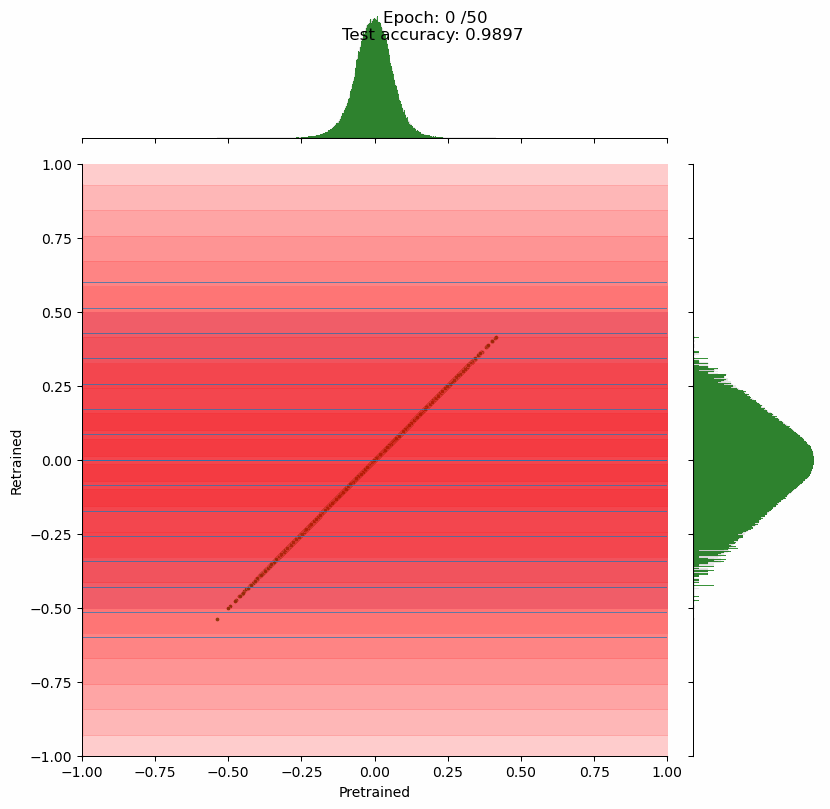

In [18]:
display.Image(filename='./figures/retraining.gif')

## PART 3: Post-processing

Now, the only thing that is left to do is setting each weight to the mean of the component that takes most responsibility for it i.e. quantising the weights. 


In [12]:
from helpers import discretesize

retrained_weights = np.copy(model.get_weights())
compressed_weights = np.copy(model.get_weights())
compressed_weights[:-3] = discretesize(compressed_weights, pi_zero = pi_zero)

/opt/anaconda3/envs/ATDL/lib/python3.9/site-packages/numpy/lib/function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


Let us compare the accuracy of the reference, the retrained and the post-processed network.

In [13]:
print("MODEL ACCURACY")
score = pretrained_model.evaluate({'input': X_test, },{"error_loss" : Y_test,}, verbose=0)[1]
print("Reference Network: %0.4f" %score)
score = model.evaluate({'input': X_test, },{"error_loss" : Y_test, "complexity_loss": Y_test,}, verbose=0)[3]
print("Retrained Network: %0.4f" %score)
model.set_weights(compressed_weights)
score = model.evaluate({'input': X_test, },{"error_loss" : Y_test, "complexity_loss": Y_test,}, verbose=0)[3]
print("Post-processed Network: %0.4f" %score)

MODEL ACCURACY


/opt/anaconda3/envs/ATDL/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-10-16 13:16:42.255070: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_1/mul' id:654 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/error_loss_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Reference Network: 0.9897
Retrained Network: 0.9901
Post-processed Network: 0.9902


Finally let us see how many weights have been pruned.

In [14]:
from helpers import special_flatten
weights = special_flatten(compressed_weights[:-3]).flatten()
print("Non-zero weights: %0.2f %%" % (100.*np.count_nonzero(weights)/ weights.size) )

Non-zero weights: 9.36 %


As we can see in this naive implementation we got rid of 19 out of 20 weights. Furthermore note that we quantize weights with only 16 cluster means (aka 4 bit indexes). 

For better results (up to 0.5%) one may anneal $\tau$, learn the mixing proportion for the zero spike with a beta prior on it for example and ideally optimize with some hyperparamter optimization of choice such as spearmint (I also wrote some example code for deep learning and spearmint).

We finish this tutorial with a series of histograms showing the results of our procedure.

In [15]:
from helpers import save_histogram

save_histogram(pretrained_model.get_weights(),save="figures/reference")
save_histogram(retrained_weights,save="figures/retrained")
save_histogram(compressed_weights,save="figures/post-processed")

/Users/gaetanotedesco/Desktop/University/UCPH/ATDL/ATDL-SoftWeightSharingForNNCompression/helpers.py:130: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(w, kde=False, color="g",bins=200,norm_hist=True)
/Users/gaetanotedesco/Desktop/University/UCPH/ATDL/ATDL-SoftWeightSharingForNNCompression/helpers.py:140: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/

|Weight distribution before retraining | Weight distribution after retraining|  Weight distribution after post-processing  
:-------------------------:|:-------------------------:|:------------:|:-------------------------:
histogram|![](figures_old/reference.png)|<img src="./figures/retrained.png"/>| ![](figures_old/post-processed.png)
log-scaled histogram|![](figures_old/reference_log.png)|<img src="./figures/retrained_log.png"/>| ![](figures_old/post-processed_log.png)
_______________________________
### *Reference*

The paper "Soft weight-sharing for Neural Network compression" has been accepted to ICLR 2017.


    @inproceedings{ullrich2017soft,
    title={Soft Weight-Sharing for Neural Network Compression},
    author={Ullrich, Karen and  Meeds, Edward and Welling, Max},
    booktitle={ICLR 2017},
    year={2017}
    }